Characterizations of data in iDigBio suitible for text mining

In [3]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [4]:
# Load iDigBio Parquet
sqlContext = SQLContext(sc)
#idbdf = sqlContext.read.parquet("../data/idigbio/occurrence.txt.parquet")
idbdf = sqlContext.read.parquet("../data/idigbio-100k/occurrence.txt.parquet")
total_records = idbdf.count()
print(total_records)

99999


Let's start with the assumption that we know what fields are useful for looking for general features (we're not interested in parsing of taxonomic history or fields that are very specific to a single feature and require lots of domain knowlege to decode data representations.)

http://rs.tdwg.org/dwc/terms/dynamicProperties
http://rs.tdwg.org/dwc/terms/fieldNotes
http://portal.idigbio.org/terms/associateNotes
http://rs.tdwg.org/dwc/terms/occurrenceRemarks
http://rs.tdwg.org/dwc/terms/eventRemarks

Of these, dynamicProperties is best left for parsing. associateNotes is an iDigBio term that I'm not sure what it is. This leaves fieldNotes, occurrenceRemarks, and eventRemarks.

How many records have something in these fields?

In [30]:
# http://www.nodalpoint.com/unexpected-behavior-of-spark-dataframe-filter-method/
# Use SQL syntax here because column names suck, alias columns to make life easier
idbdf.registerTempTable("idbtable")
notes = sqlContext.sql("""
                       SELECT
                       `http://portal.idigbio.org/terms/uuid` as uuid,
                       `http://rs.tdwg.org/dwc/terms/occurrenceID` as occurrenceID,
                       `http://rs.tdwg.org/dwc/terms/catalogNumber` as catalogNumber,
                       `http://rs.tdwg.org/dwc/terms/county` as county,
                       `http://rs.tdwg.org/dwc/terms/institutionCode` as institutionCode,
                       `http://rs.tdwg.org/dwc/terms/country` as country,
                       `http://rs.tdwg.org/dwc/terms/countryCode` as countryCode,
                       `http://rs.tdwg.org/dwc/terms/stateProvince` as stateProvince,
                       `http://rs.tdwg.org/dwc/terms/family` as family,
                       `http://rs.tdwg.org/dwc/terms/recordedBy` as recordedBy,
                       `http://rs.tdwg.org/dwc/terms/order` as order,
                       `http://rs.tdwg.org/dwc/terms/specificEpithet` as specificEpithet,
                       `http://rs.tdwg.org/dwc/terms/genus` as genus,
                       `http://rs.tdwg.org/dwc/terms/sex` as sex,
                       `http://rs.tdwg.org/dwc/terms/scientificName` as scientificName,
                       `http://rs.tdwg.org/dwc/terms/year` as year,
                       `http://rs.tdwg.org/dwc/terms/month` as month,
                       CONCAT(`http://rs.tdwg.org/dwc/terms/fieldNotes`, ' ',
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks`, ' ',
                       `http://rs.tdwg.org/dwc/terms/eventRemarks`
                       ) as document
                       FROM idbtable WHERE 
                       `http://rs.tdwg.org/dwc/terms/fieldNotes` != '' OR
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` != '' OR 
                       `http://rs.tdwg.org/dwc/terms/eventRemarks` != ''
                       """)
notes_records = notes.count()
print(notes_records)
print(1.0 * notes_records/total_records * 100)
for r in notes.head(10):
    print(r['document'])


ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 23))



Py4JJavaError: An error occurred while calling o19.sql.
: java.lang.RuntimeException: [13.69] failure: ``by'' expected but `,' found

                       `http://rs.tdwg.org/dwc/terms/order` as order,

                                                                    ^
	at scala.sys.package$.error(package.scala:27)
	at org.apache.spark.sql.catalyst.AbstractSparkSQLParser.parse(AbstractSparkSQLParser.scala:36)
	at org.apache.spark.sql.catalyst.DefaultParserDialect.parse(ParserDialect.scala:67)
	at org.apache.spark.sql.SQLContext$$anonfun$2.apply(SQLContext.scala:211)
	at org.apache.spark.sql.SQLContext$$anonfun$2.apply(SQLContext.scala:211)
	at org.apache.spark.sql.execution.SparkSQLParser$$anonfun$org$apache$spark$sql$execution$SparkSQLParser$$others$1.apply(SparkSQLParser.scala:114)
	at org.apache.spark.sql.execution.SparkSQLParser$$anonfun$org$apache$spark$sql$execution$SparkSQLParser$$others$1.apply(SparkSQLParser.scala:113)
	at scala.util.parsing.combinator.Parsers$Success.map(Parsers.scala:136)
	at scala.util.parsing.combinator.Parsers$Success.map(Parsers.scala:135)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$map$1.apply(Parsers.scala:242)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$map$1.apply(Parsers.scala:242)
	at scala.util.parsing.combinator.Parsers$$anon$3.apply(Parsers.scala:222)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$append$1$$anonfun$apply$2.apply(Parsers.scala:254)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$append$1$$anonfun$apply$2.apply(Parsers.scala:254)
	at scala.util.parsing.combinator.Parsers$Failure.append(Parsers.scala:202)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$append$1.apply(Parsers.scala:254)
	at scala.util.parsing.combinator.Parsers$Parser$$anonfun$append$1.apply(Parsers.scala:254)
	at scala.util.parsing.combinator.Parsers$$anon$3.apply(Parsers.scala:222)
	at scala.util.parsing.combinator.Parsers$$anon$2$$anonfun$apply$14.apply(Parsers.scala:891)
	at scala.util.parsing.combinator.Parsers$$anon$2$$anonfun$apply$14.apply(Parsers.scala:891)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:57)
	at scala.util.parsing.combinator.Parsers$$anon$2.apply(Parsers.scala:890)
	at scala.util.parsing.combinator.PackratParsers$$anon$1.apply(PackratParsers.scala:110)
	at org.apache.spark.sql.catalyst.AbstractSparkSQLParser.parse(AbstractSparkSQLParser.scala:34)
	at org.apache.spark.sql.SQLContext$$anonfun$1.apply(SQLContext.scala:208)
	at org.apache.spark.sql.SQLContext$$anonfun$1.apply(SQLContext.scala:208)
	at org.apache.spark.sql.execution.datasources.DDLParser.parse(DDLParser.scala:43)
	at org.apache.spark.sql.SQLContext.parseSql(SQLContext.scala:231)
	at org.apache.spark.sql.SQLContext.sql(SQLContext.scala:817)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


Lets do some string length calcuations and make some new columns in Spark before switching to Pandas

What are typical lengths of text to work with here? Histogram of length of the document texts

In [6]:
# make a Pandas data frame to work with, this is expensive-ish depending on data size, 
# perhaps we should cut back on the columns in the select statement and alias them to make
# life better? -- OOM's with full data set
notes_pd = notes.toPandas()

<class 'pandas.core.frame.DataFrame'>


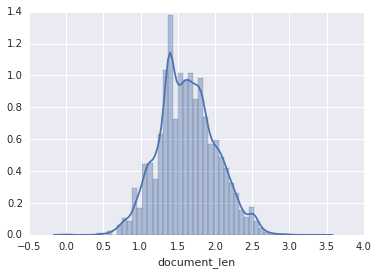

In [24]:
print(type(notes_pd))

# I guess there are some None's in the column...
def wow(r):
    if r['document'] is None:
        return 0
    else:
        return math.log10(len(r['document']))
    
notes_pd['document_len'] = notes_pd.apply(lambda r: wow(r), axis=1) 
#print(notes_pd.head())
sns.distplot(notes_pd['document_len'])

In [27]:
# Really, I have ones that are 10k characters? - no, base e vs base 10,
#have ~50 - 200 characters
first_row = notes_pd.loc[notes_pd['document_len'] > 1.5].head(1)
# Why can't I just print the contents?
print(first_row['document_len'])
print('"')
for c in first_row['document']:
    print(c)
print('"')

0    1.838849
Name: document_len, dtype: float64
"
 SVL 43.0 mm, Total 112.0 mm, WT 1.1 gm.  Time constrained searches. 
"
